In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold

from numpy.typing import ArrayLike
from typing import Callable

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

import yaml
import joblib

import warnings
warnings.filterwarnings('ignore')

# Overview

Данные взяты из соревания на Kaggle. Основная информация по данным представлена здесь https://www.kaggle.com/competitions/home-credit-credit-risk-model-stability/data

Цель - предсказать, какие клиенты с большей вероятностью не смогут выплатить свои кредиты. Оценка должна быть стабильна с течением времени

# Evaluation

Результаты оцениваются с использованием показателя стабильности Джини. Показатель Джини рассчитывается для предсказаний, соответствующих каждой неделе WEEK_NUMBER:
<center><font size="4">gini=2∗AUC−1</center>

Далее линейная регрессия, <font size="4">a⋅x+b</font>, обучается на еженедельных показателях коэффициента Джини, и falling_rate рассчитывается как <font size="4">min(0,a)</font>. Это используется для штрафования моделей.
   
В итоге, вариабельность предсказаний рассчитывается путем взятия стандартного отклонения остатков (residuals) из приведенной выше линейной регрессии с применением штрафа к изменчивости модели.

Итоговая метрика рассчитывается следующим образом:
<center><font size="4">stability metric=mean(gini)+88.0⋅min(0,a)−0.5⋅std(residuals)</center>

In [266]:
def gini_stability(y_test: ArrayLike,
                   y_score: ArrayLike,
                   weeks: pd.Series,
                   w_fallingrate: float = 88.0,
                   w_resstd: float = -0.5) -> float:
    """
    Расчет показателя стабильности Джини.
    
    Показатель Джини рассчитывается для предсказаний, соответствующих каждой неделе
    Итоговая метрика рассчитывается по формуле:
        stability metric=mean(gini)+88.0⋅min(0,a)−0.5⋅std(residuals)
    :param y_test: фактические целевые значения
    :param y_score: предсказанные вероятности
    :param weeks: недели
    :param w_fallingrate: коэффициент 
    :param w_resstd: коэффициент
    :return: метрика
    """
    df_score = pd.DataFrame(y_score, columns=["score"])
    df_score["week"] = weeks.to_numpy()
    df_score["target"] = y_test.to_numpy()

    gini_in_time = df_score.loc[:, ["week", "target", "score"]] \
        .sort_values("week") \
        .groupby("week")[["target", "score"]] \
        .apply(lambda x: 2 * roc_auc_score(x["target"], x["score"]) - 1) \
        .tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a * x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    mean_gini = np.mean(gini_in_time)
    metric = mean_gini + w_fallingrate * min(0, a) + w_resstd * res_std
    return metric


def get_metrics(y_test: pd.Series, y_pred: pd.Series, y_score: ArrayLike,
                weeks: pd.Series, name: str) -> pd.DataFrame:
    """
    Расчет метрики и генерация датафрейма с метриками
    """
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['gini_stability'] = gini_stability(y_test, y_score[:, 1], weeks)

    return df_metrics


def check_overfitting(metric_fun: Callable,
                      y_train: pd.Series,
                      y_test: pd.Series,
                      X_train: pd.DataFrame = None,
                      X_test: pd.DataFrame = None,
                      model: BaseEstimator = None,
                      y_pred_train: pd.DataFrame = None,
                      y_pred_test: pd.DataFrame = None):
    """
    Проверка модели на переобучение.
    """
    if model is None:
        value_train = metric_fun(y_train, y_pred_train)
        value_test = metric_fun(y_test, y_pred_test)
    else:
        if metric_fun.__name__ == 'roc_auc_score':
            y_pred_train = model.predict_proba(X_train)[:, 1]
            y_pred_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        value_train = metric_fun(y_train, y_pred_train)
        value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(
        f'delta = {(abs(value_train - value_test) / value_test * 100):.1f} %')

# Prepare data

In [267]:
config_path = '../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

preproc_config = config['preprocessing']
training_config = config['train']

In [268]:
preproc_config["train_path_proc"]

'../data/processed/train.parquet'

In [269]:
df_train = pd.read_parquet(preproc_config["train_path_proc"])
df_train.head()

,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,...,mode_collaterals_typeofguarante_669M,mean_pmts_dpd_1073P,mean_pmts_dpd_303P,max_pmts_year_1139T,max_pmts_year_507T,mode_subjectroles_name_541M,month_decision,weekday_decision,age,age_bins
0,19,0,0,0.00,12544.8000,0.0,0,0,0,0,...,a55475b1,0,0,-1,0,a55475b1,5,6,22,small
1,39,0,0,0.00,1895.6000,0.0,0,0,0,0,...,a55475b1,0,0,-1,0,a55475b1,10,7,32,small
2,47,0,0,0.00,1768.0000,0.0,0,0,0,0,...,a55475b1,0,0,-1,0,a55475b1,11,4,34,small
3,55,0,0,0.00,3010.6000,0.0,0,0,0,0,...,Unknown,0,0,0,0,Unknown,1,6,21,small
4,26,0,0,66877.71,3548.4001,2486.6,0,0,0,0,...,a55475b1,0,0,-1,-1,a55475b1,7,2,58,large


In [270]:
training_config["target_column"]

'target'

In [271]:
training_config["groups_column"]

'WEEK_NUM'

In [272]:
drop_columns = [
    training_config["groups_column"],
    training_config["target_column"]
]
drop_columns

['WEEK_NUM', 'target']

In [273]:
X = df_train.drop(columns=drop_columns, axis=1)
y = df_train[training_config["target_column"]]
groups = df_train[training_config["groups_column"]]

Т.к. метрика стабильности gini рассчитывается для каждой группы (в данном случае для каждого значениям WEEK_NUM), то будем делить датасет в разрезе WEEK_NUM, чтобы значения WEEK_NUM не пересакались в тестовом и тренировочном датасете

In [11]:
def train_test_split_by_groups(X: pd.DataFrame,
                               y: pd.Series,
                               groups: pd.Series,
                               test_size=None,
                               train_size=None,
                               random_state=None):
    """
    Split arrays or matrices into random train and test subsets 
    according groups.
    """
    gss = GroupShuffleSplit(n_splits=1,
                            test_size=test_size,
                            train_size=train_size,
                            random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))
    return X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx],\
        y.iloc[test_idx], groups.iloc[train_idx], groups.iloc[test_idx]

In [12]:
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split_by_groups(
    X, 
    y, 
    groups, 
    test_size=training_config["test_size"], 
    random_state=training_config["random_state"])

print(f"train: {round(X_train.shape[0] / X.shape[0] * 100, 2)}%")
print(f"test: {round(X_test.shape[0] / X.shape[0] * 100, 2)}%")

train: 73.01%
test: 26.99%


In [13]:
print(g_train.unique())
print(g_test.unique())

[39 47 55 26  1 61 14 43 59 56 50 89  3 83]
[19 34 84 38 35]


In [14]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
ratio

26.79368100494861

# Training

In [15]:
%%time

lgbm_clf = lgb.LGBMClassifier(scale_pos_weight=ratio,
                              random_state=training_config["random_state"])
lgbm_clf.fit(X_train, y_train, callbacks=[lgb.log_evaluation(100)])

[LightGBM] [Info] Number of positive: 2627, number of negative: 70387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28436
[LightGBM] [Info] Number of data points in the train set: 73014, number of used features: 242
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035979 -> initscore=-3.288166
[LightGBM] [Info] Start training from score -3.288166
CPU times: total: 8.94 s
Wall time: 1.81 s


LGBMClassifier(random_state=10, scale_pos_weight=26.79368100494861)

In [16]:
check_overfitting(model=lgbm_clf,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.962
roc_auc_score test: 0.803
delta = 19.8 %


In [220]:
metrics = get_metrics(y_test, lgbm_clf.predict(X_test),
                      lgbm_clf.predict_proba(X_test), g_test,
                      'LGBMClassifier_baseline_test')

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.84281,0.80306,0.10373,0.56658,0.17535,0.57538


# Tuning

In [207]:
def lgb_fit_cross_validation(trial,
                             X,
                             y,
                             groups,
                             n_folds,
                             random_state=10,
                             lgb_params: dict = None):
    """
    Fit LGBMClassifier with cross-validation
    """
    cv = StratifiedGroupKFold(n_splits=n_folds,
                              shuffle=True,
                              random_state=random_state)

    cv_predicts = np.empty(n_folds)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups=groups)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, "auc")
        model = lgb.LGBMClassifier(scale_pos_weight=ratio, **lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric="auc",
                  callbacks=[lgb.early_stopping(100, verbose=False), 
                             pruning_callback
                            ])

        predicts_proba = model.predict_proba(X_val)[:, 1]
        cv_predicts[idx] = roc_auc_score(y_val, predicts_proba)

    return np.mean(cv_predicts)

In [208]:
def objective_lr(trial, X, y, groups, n_folds, random_state=10):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [500]),
        "learning_rate": trial.suggest_float("learning_rate",
                                             0.001,
                                             0.3,
                                             log=True),
        "random_state": trial.suggest_categorical("random_state",
                                                  [random_state]),
        "verbose": trial.suggest_categorical("verbose", [-1]),
    }

    return lgb_fit_cross_validation(trial, X, y, groups, n_folds, random_state,
                                    lgb_params)

In [209]:
study_lr = optuna.create_study(direction="maximize",
                               study_name="LGB1",
                               pruner=optuna.pruners.SuccessiveHalvingPruner())
func = lambda trial: objective_lr(trial,
                                  X_train,
                                  y_train,
                                  g_train,
                                  n_folds=training_config["n_folds"],
                                  random_state=training_config["random_state"])
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_lr.optimize(func,
                  n_trials=training_config["n_trials"],
                  show_progress_bar=True)

print(f"\tBest value (auc): {study_lr.best_value:.5f}")
print(f"\tBest params: {study_lr.best_params}")

  0%|          | 0/30 [00:00<?, ?it/s]

	Best value (auc): 0.77848
	Best params: {'n_estimators': 500, 'learning_rate': 0.24405895875796788, 'random_state': 10, 'verbose': -1}


In [210]:
lr_best = study_lr.best_params["learning_rate"]
lr_best

0.24405895875796788

In [211]:
def objective_other(trial,
                    X,
                    y,
                    groups,
                    n_folds,
                    learning_rate,
                    random_state=10):
    lgb_params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [500]),
        "learning_rate":
        trial.suggest_categorical("learning_rate", [learning_rate]),
        "num_leaves":
        trial.suggest_int("num_leaves", 20, 1000, step=20),
        "max_depth":
        trial.suggest_int("max_depth", 4, 10),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 100, 70000, step=100),
        "reg_alpha":
        trial.suggest_float("reg_alpha", 1e-3, 1e2, log=True),
        "reg_lambda":
        trial.suggest_float("reg_lambda", 1e-3, 1e2, log=True),
        "min_split_gain":
        trial.suggest_int("min_gain_to_split", 0, 20),
#         "subsample":
#         trial.suggest_float("subsample", 0.2, 1.0),
#         "subsample_freq":
#         trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.4, 0.9),
        "colsample_bynode":
        trial.suggest_float("colsample_bynode", 0.4, 0.9),
        "random_state":
        trial.suggest_categorical("random_state", [random_state]),
        "verbose":
        trial.suggest_categorical("verbose", [-1]),
    }

    return lgb_fit_cross_validation(trial, X, y, groups, n_folds, random_state,
                                    lgb_params)

In [212]:
%%time
study_other = optuna.create_study(
    direction="maximize",
    study_name="LGB2",
    pruner=optuna.pruners.SuccessiveHalvingPruner())
func = lambda trial: objective_other(trial,
                                     X_train,
                                     y_train,
                                     g_train,
                                     n_folds=training_config["n_folds"],
                                     learning_rate=lr_best,
                                     random_state=training_config[
                                         "random_state"])
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_other.optimize(func,
                     n_trials=training_config["n_trials"],
                     show_progress_bar=True)

print(f"\tBest value (auc): {study_other.best_value:.5f}")
print(f"\tBest params: {study_other.best_params}")

  0%|          | 0/30 [00:00<?, ?it/s]

	Best value (auc): 0.81719
	Best params: {'n_estimators': 500, 'learning_rate': 0.24405895875796788, 'num_leaves': 160, 'max_depth': 7, 'min_child_samples': 8500, 'reg_alpha': 60.70256297575793, 'reg_lambda': 0.30599465458489233, 'min_gain_to_split': 1, 'colsample_bytree': 0.8154702383821479, 'colsample_bynode': 0.6697202243436582, 'random_state': 10, 'verbose': -1}
CPU times: total: 4min 21s
Wall time: 53.1 s


In [213]:
optuna.visualization.plot_param_importances(study_other)

In [214]:
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study_other)
fig.show(config=plotly_config)

In [256]:
best_params = study_other.best_params
best_params

{'n_estimators': 500,
 'learning_rate': 0.24405895875796788,
 'num_leaves': 160,
 'max_depth': 7,
 'min_child_samples': 8500,
 'reg_alpha': 60.70256297575793,
 'reg_lambda': 0.30599465458489233,
 'min_gain_to_split': 1,
 'colsample_bytree': 0.8154702383821479,
 'colsample_bynode': 0.6697202243436582,
 'random_state': 10,
 'verbose': -1}

# Train with best params

In [216]:
%%time

lgbm_clf_opt = lgb.LGBMClassifier(scale_pos_weight=ratio, **best_params)
lgbm_clf_opt.fit(X_train, y_train, callbacks=[lgb.log_evaluation(100)])

CPU times: total: 15.4 s
Wall time: 2.8 s


LGBMClassifier(colsample_bynode=0.6697202243436582,
               colsample_bytree=0.8154702383821479,
               learning_rate=0.24405895875796788, max_depth=7,
               min_child_samples=8500, min_gain_to_split=1, n_estimators=500,
               num_leaves=160, random_state=10, reg_alpha=60.70256297575793,
               reg_lambda=0.30599465458489233,
               scale_pos_weight=26.79368100494861, verbose=-1)

In [217]:
check_overfitting(model=lgbm_clf_opt,
                  metric_fun=roc_auc_score,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test)

roc_auc_score train: 0.920
roc_auc_score test: 0.810
delta = 13.6 %


In [218]:
get_metrics(y_test, lgbm_clf_opt.predict(X_test),
                lgbm_clf_opt.predict_proba(X_test), g_test,
                'LGBMClassifier_optuna_test')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
0,LGBMClassifier_optuna_test,0.816423,0.80953,0.093628,0.601759,0.162043,0.590035


In [221]:
metrics = pd.concat([
    metrics,
    get_metrics(y_test, lgbm_clf_opt.predict(X_test),
                lgbm_clf_opt.predict_proba(X_test), g_test,
                'LGBMClassifier_optuna_test')
])

round(metrics.set_index('model'), 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,gini_stability
model,,,,,,
LGBMClassifier_baseline_test,0.84281,0.80306,0.10373,0.56658,0.17535,0.57538
LGBMClassifier_optuna_test,0.81642,0.80953,0.09363,0.60176,0.16204,0.59003


# Saving

In [257]:
with open(training_config['params_path'], 'w') as f:
    json.dump(best_params, f)

In [258]:
training_config['model_path']

'../models/model_lgb.joblib'

In [262]:
joblib.dump(lgbm_clf_opt, training_config['model_path'])

['../models/model_lgb.joblib']

In [259]:
training_config['metrics_path']

'../report/metrics.json'

In [264]:
with open(training_config['metrics_path'], 'w') as f:
    json.dump(metrics.to_dict(), f)

# Finance (сравнение с бейзлайном)

In [101]:
def plot_confusion_matrix(y_true, X, ax, model=None, prediction=None):
    """Визуализация ConfusionMatrix"""
    if prediction is None:
        prediction = model.predict(X_test)
        
    labels = list(set(prediction))
    cm_ovr = confusion_matrix(y_test, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ovr, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)

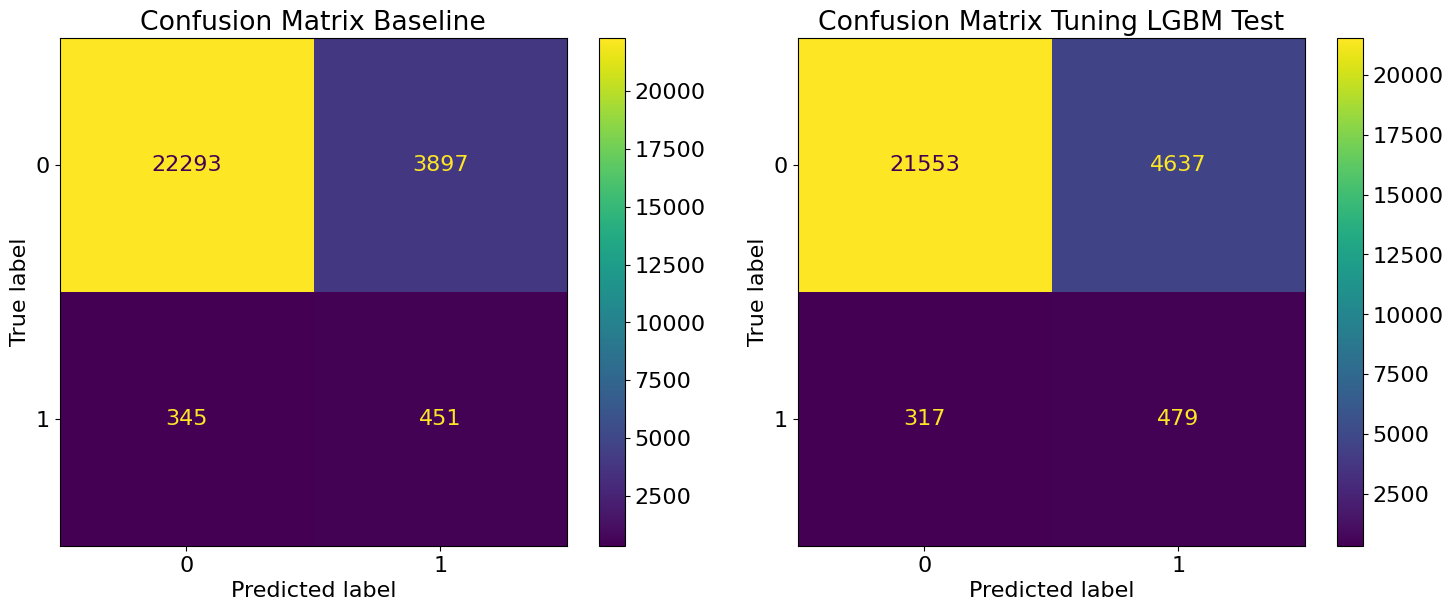

In [219]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=lgbm_clf, y_true=y_test, X=X_test, ax=ax[0])
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(model=lgbm_clf_opt, y_true=y_test, X=X_test, ax=ax[1])

ax[0].title.set_text('Confusion Matrix Baseline')
ax[1].title.set_text('Confusion Matrix Tuning LGBM Test')
plt.tight_layout()  
plt.show()

In [277]:
def finance(model,
            y_test,
            X_test,
            loan_amount=50000,
            period_in_month=12,
            monthly_payment=5000,
            debug=False):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()

    # процентный доход с одного клиента
    interest_income = monthly_payment * period_in_month - loan_amount
    
    # продали и клиент выплатил кредит
    cell = tn * interest_income
    
    # потеряли (продали, но клиент не выплатил кредит)
    spent_money = fn * loan_amount
    
    # потенциальная выручка (кол-во клиентов выплативших кредит * процентный доход)
    potential_income = y_test.value_counts()[0] * interest_income

    # итоговая выручка
    result_income = cell - spent_money
    # процент от предполагаемой выручки
    percent = round(result_income / potential_income * 100, 1)
    
    if debug:            
        # сохранили денег (правильно предсказали дефолт)
        save_money = tp * loan_amount
        # не дополучили выручки (неверно определили потенциальных клиентов)
        lost_money = fp * interest_income
        
        print(f"Процентный доход с одного клиента: {interest_income}")    
        print(f"Получили: {tn} * {interest_income} = {cell}")
        print(f"Потеряли: {fn} * {loan_amount} = {spent_money}")        
        print(f"Сохранили: {tp} * {loan_amount} = {save_money}")
        print(f"Не дополучили: {fp} * {interest_income} = {lost_money}")
        print(f"Итого выручка: {result_income}")
        print(f"Процент от предполагаемой выручки: {percent}")
    
    return result_income, percent

In [278]:
finance(lgbm_clf, y_test, X_test, debug=True)

Процентный доход с одного клиента: 10000
Получили: 22293 * 10000 = 222930000
Потеряли: 345 * 50000 = 17250000
Сохранили: 451 * 50000 = 22550000
Не дополучили: 3897 * 10000 = 38970000
Итого выручка: 205680000
Процент от предполагаемой выручки: 78.5


(205680000, 78.5)

In [279]:
finance(lgbm_clf_opt, y_test, X_test, debug=True)

Процентный доход с одного клиента: 10000
Получили: 21553 * 10000 = 215530000
Потеряли: 317 * 50000 = 15850000
Сохранили: 479 * 50000 = 23950000
Не дополучили: 4637 * 10000 = 46370000
Итого выручка: 199680000
Процент от предполагаемой выручки: 76.2


(199680000, 76.2)

In [280]:
percent_delta = round(
    finance(lgbm_clf_opt, y_test, X_test)[1] -
    finance(lgbm_clf, y_test, X_test)[1], 1)

money_delta = finance(lgbm_clf_opt, y_test, X_test)[0] - finance(
    lgbm_clf, y_test, X_test)[0]

print(f'разница в выручках в % у моделей = {percent_delta}%')
print(f'разница в выручках у моделей = {money_delta}')

разница в выручках в % у моделей = -2.3%
разница в выручках у моделей = -6000000


**Выводы**
- хотя по метрикам модель стала лучше предсказывать, но видим, что по финансовым показателям переобученная модель дает лучший результат - текущая выборка очень сильно несбалансирована, поэтому за счет более правильного определения клиентов, которые вернут кредит (TN), итоговая сумма baseline модели получилась выше